In [5]:
!pip install torchvision

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB 435.7 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.6 MB 871.5 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.6 MB 1.3 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.6 MB 1.5 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.6 MB 1.8 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.6 MB 1.8 MB/s eta 0:00:01
   -------------- ------------------------- 0.6/1.6 MB 2.0 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.6 MB 2.3 MB/s eta 0:00:01
   ---------------------- ----------------- 0.9/1.6 MB 2.4 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.6 MB 2.5 MB/s eta 0:00:01
   ---------------------------- ----------- 1.1/1.6 MB 2.6 MB/s eta 0:00:01
   -------------------

In [6]:
import os
import pandas as pd
import cv2
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [29]:
def load_data_with_metadata(project_path):
    data = []
    for folder in os.listdir(project_path):
        folder_path = os.path.join(project_path, folder)
        # print(folder_path)
        if os.path.isdir(folder_path):
            # Extract participant# and simulation_name from folder name
            try:
                parts = folder.split("_", maxsplit=2)
                participant_id = parts[0]  # Participant number (e.g., "400")
                simulation_name = parts[2] if len(parts) > 2 else "Unknown"  # Simulation name (e.g., "Frisbee_Golf")
            except IndexError:
                participant_id = "Unknown"
                simulation_name = "Unknown"
            # print(participant_id)
            # print(simulation_name)
            
            # Identify subdirectories/files
            video_folder = os.path.join(folder_path, "video")  # Adjust this if necessary
            # print(video_folder)
            log_file = os.path.join(folder_path, "VRMS_Log.csv")
            
            if os.path.exists(video_folder) and os.path.exists(log_file):
                log_data = pd.read_csv(log_file)
                image_files = sorted(os.listdir(video_folder))  # Sort image files by name
                # print(image_files)
                # Extract timestamps from image files
                image_timestamps = []
                for image_file in image_files:
                    try:
                        image_timestamp = int(image_file.split("_")[1].split(".")[0])
                        image_timestamps.append((image_timestamp, image_file))
                    except (IndexError, ValueError):
                        continue
                
                # Sort by timestamp
                image_timestamps.sort()
                # print(image_timestamps)

                for i, row in log_data.iterrows():
                    # Define the current and next timestamps
                    current_timestamp = int(row["Timestamp"])
                    # print(current_timestamp)
                    next_timestamp = log_data.iloc[i + 1]["Timestamp"] if i + 1 < len(log_data) else float("inf")
                    # print(next_timestamp)
                    
                    # Find the starting frame
                    starting_frame = None
                    for timestamp, image_file in image_timestamps:
                        if timestamp >= current_timestamp:
                            starting_frame = image_file
                            print(starting_frame)
                            break
                    
                    # Find the ending frame
                    ending_frame = None
                    for timestamp, image_file in reversed(image_timestamps):
                        if timestamp < next_timestamp:
                            ending_frame = image_file
                            break
                    
                    # Append the result if both frames are found
                    # if starting_frame and ending_frame:
                    data.append({
                        "participant_id": participant_id,
                        "simulation_name": simulation_name,
                        # "starting_frame": os.path.join(video_folder, starting_frame),
                        # "ending_frame": os.path.join(video_folder, ending_frame),
                        "label": row["Key"]
                    })
    return pd.DataFrame(data)

# Example Usage
project_path = r"C:\Users\jyoti\OneDrive\Documents\SAVE\ISMAR_IEEEVR25\Vr_net\Data_26\content\test1"
data_df = load_data_with_metadata(project_path)
print(data_df.head())


  participant_id simulation_name  label
0            400   Delivery_Dash      1
1            400   Delivery_Dash      1
2            400   Delivery_Dash      1
3            400   Delivery_Dash      2
4            400   Delivery_Dash      2


In [30]:
data_df

,participant_id,simulation_name,label
0,400,Delivery_Dash,1
1,400,Delivery_Dash,1
2,400,Delivery_Dash,1
3,400,Delivery_Dash,2
4,400,Delivery_Dash,2
...,...,...,...
378,414,Live_Sandbox,3
379,414,Live_Sandbox,3
380,414,Live_Sandbox,3
381,414,Live_Sandbox,4


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Assuming `df` is your input DataFrame
# Example: df = pd.read_csv("path/to/your/file.csv")

# Descriptive analysis grouped by simulation_name
grouped_stats = data_df.groupby('simulation_name')['label'].describe()
print(grouped_stats)


                 count      mean       std  min  25%  50%  75%  max
simulation_name                                                    
Delivery_Dash     39.0  1.282051  0.510352  1.0  1.0  1.0  1.5  3.0
Frisbee_Golf      39.0  1.435897  0.852083  1.0  1.0  1.0  1.0  4.0
Junior_Chef       26.0  2.000000  0.800000  1.0  1.0  2.0  3.0  3.0
Live_Sandbox      26.0  1.730769  0.961569  1.0  1.0  1.0  2.0  4.0
Red_Dead         129.0  1.689922  1.102543  1.0  1.0  1.0  2.0  5.0
VR_Bank          124.0  1.991935  1.078210  1.0  1.0  2.0  3.0  5.0


C:\Users\jyoti\AppData\Local\Temp\ipykernel_17336\601128968.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_df, x='simulation_name', y='label', palette='Set2')


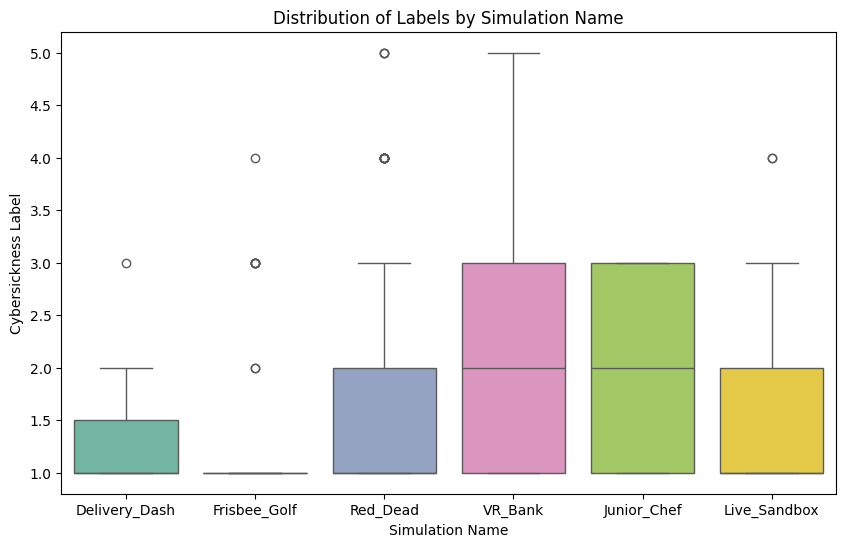

In [33]:
# Boxplot for visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df, x='simulation_name', y='label', palette='Set2')
plt.title('Distribution of Labels by Simulation Name')
plt.ylabel('Cybersickness Label')
plt.xlabel('Simulation Name')
plt.show()


In [35]:
# Perform pairwise t-tests between simulations
simulation_groups = data_df.groupby('simulation_name')['label']

for sim1 in simulation_groups.groups.keys():
    for sim2 in simulation_groups.groups.keys():
        if sim1 < sim2:  # Avoid duplicate comparisons
            group1 = simulation_groups.get_group(sim1)
            group2 = simulation_groups.get_group(sim2)
            
            # Perform independent t-test
            t_stat, p_value = ttest_ind(group1, group2)
            print(f"T-Test between {sim1} and {sim2}: t-stat = {t_stat:.2f}, p-value = {p_value:.4f}")


T-Test between Delivery_Dash and Frisbee_Golf: t-stat = -0.97, p-value = 0.3365
T-Test between Delivery_Dash and Junior_Chef: t-stat = -4.42, p-value = 0.0000
T-Test between Delivery_Dash and Live_Sandbox: t-stat = -2.45, p-value = 0.0171
T-Test between Delivery_Dash and Red_Dead: t-stat = -2.24, p-value = 0.0267
T-Test between Delivery_Dash and VR_Bank: t-stat = -3.97, p-value = 0.0001
T-Test between Frisbee_Golf and Junior_Chef: t-stat = -2.68, p-value = 0.0094
T-Test between Frisbee_Golf and Live_Sandbox: t-stat = -1.30, p-value = 0.1990
T-Test between Frisbee_Golf and Red_Dead: t-stat = -1.32, p-value = 0.1876
T-Test between Frisbee_Golf and VR_Bank: t-stat = -2.94, p-value = 0.0037
T-Test between Junior_Chef and Live_Sandbox: t-stat = 1.10, p-value = 0.2777
T-Test between Junior_Chef and Red_Dead: t-stat = 1.36, p-value = 0.1752
T-Test between Junior_Chef and VR_Bank: t-stat = 0.04, p-value = 0.9713
T-Test between Live_Sandbox and Red_Dead: t-stat = 0.18, p-value = 0.8607
T-Test b

In [36]:
# Descriptive statistics for each participant grouped by simulation
participant_stats = data_df.groupby(['participant_id', 'simulation_name'])['label'].describe()
print(participant_stats)


                                count      mean       std  min   25%  50%  \
participant_id simulation_name                                              
400            Delivery_Dash     13.0  1.846154  0.554700  1.0  2.00  2.0   
               Frisbee_Golf      13.0  2.307692  1.031553  1.0  1.00  3.0   
401            Delivery_Dash     13.0  1.000000  0.000000  1.0  1.00  1.0   
               Frisbee_Golf      13.0  1.000000  0.000000  1.0  1.00  1.0   
402            Delivery_Dash     13.0  1.000000  0.000000  1.0  1.00  1.0   
               Frisbee_Golf      13.0  1.000000  0.000000  1.0  1.00  1.0   
403            Red_Dead          12.0  2.666667  1.302678  1.0  1.75  3.0   
               VR_Bank           13.0  2.461538  0.660225  1.0  2.00  3.0   
404            Red_Dead          13.0  2.615385  1.043908  1.0  2.00  3.0   
               VR_Bank            7.0  3.285714  1.380131  1.0  2.50  4.0   
405            Red_Dead          13.0  1.000000  0.000000  1.0  1.00  1.0   

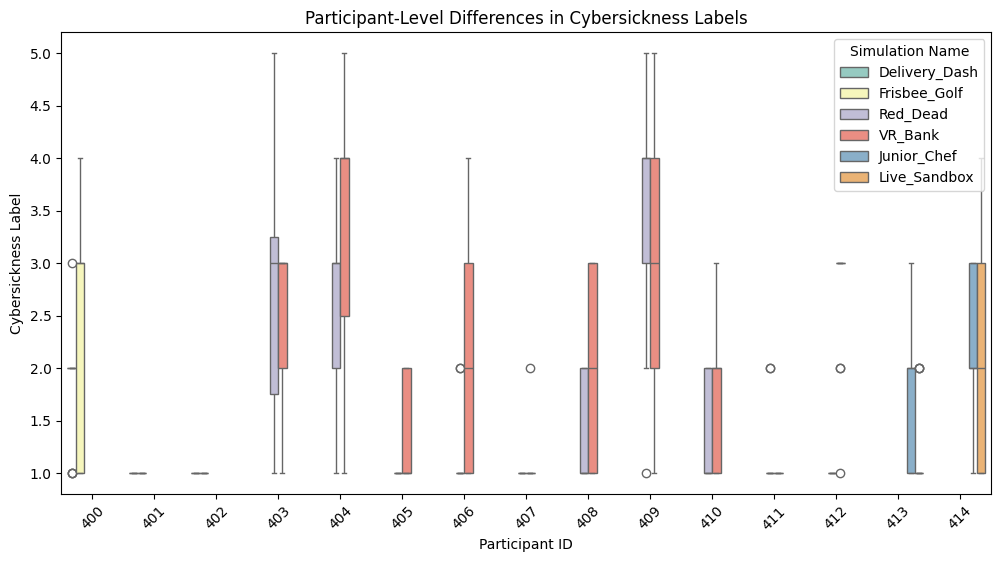

In [38]:
# Boxplot for participant-level differences
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_df, x='participant_id', y='label', hue='simulation_name', palette='Set3')
plt.title('Participant-Level Differences in Cybersickness Labels')
plt.ylabel('Cybersickness Label')
plt.xlabel('Participant ID')
plt.legend(title='Simulation Name')
plt.xticks(rotation=45)
plt.show()


                 count      mean       std  min  25%  50%  75%  max
simulation_name                                                    
Delivery_Dash     39.0  1.282051  0.510352  1.0  1.0  1.0  1.5  3.0
Frisbee_Golf      39.0  1.435897  0.852083  1.0  1.0  1.0  1.0  4.0
Junior_Chef       26.0  2.000000  0.800000  1.0  1.0  2.0  3.0  3.0
Live_Sandbox      26.0  1.730769  0.961569  1.0  1.0  1.0  2.0  4.0
Red_Dead         129.0  1.689922  1.102543  1.0  1.0  1.0  2.0  5.0
VR_Bank          124.0  1.991935  1.078210  1.0  1.0  2.0  3.0  5.0


C:\Users\jyoti\AppData\Local\Temp\ipykernel_17336\2557363260.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='simulation_name', y='label', palette='Set2')


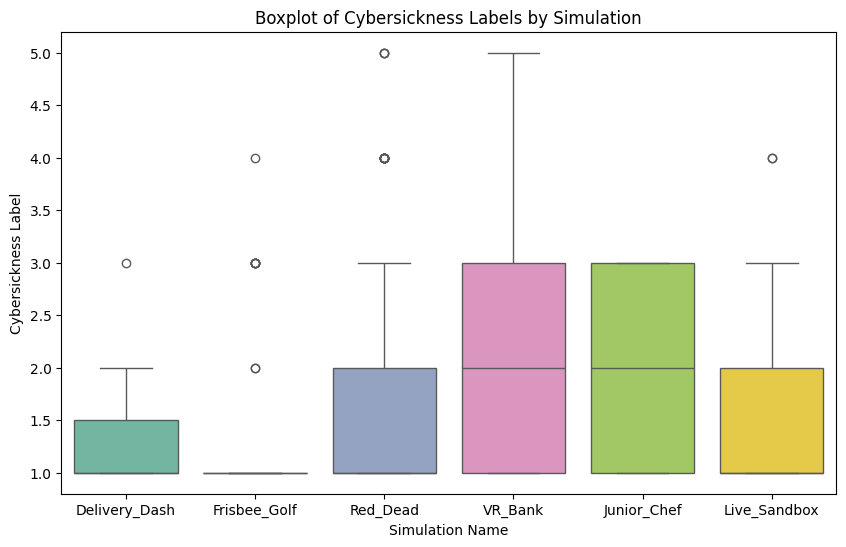

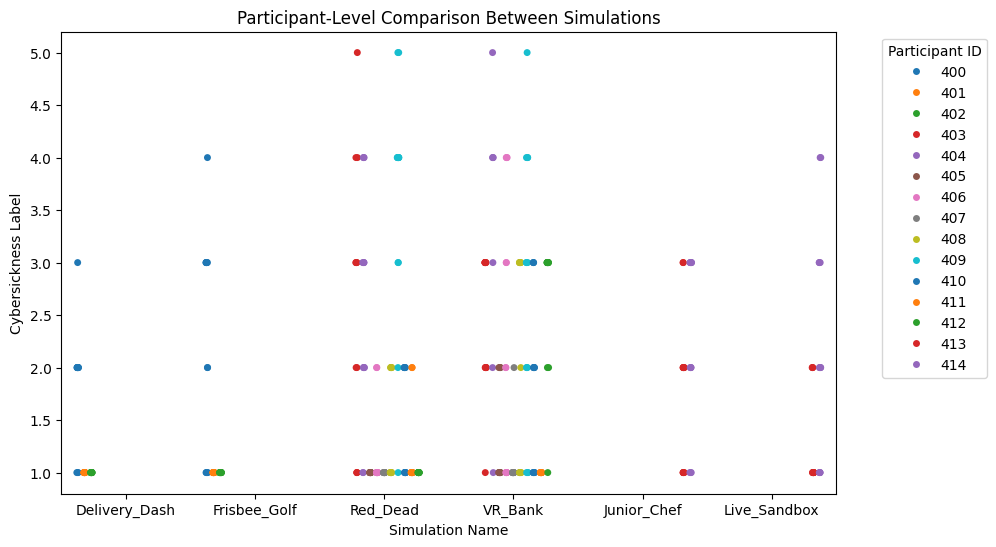

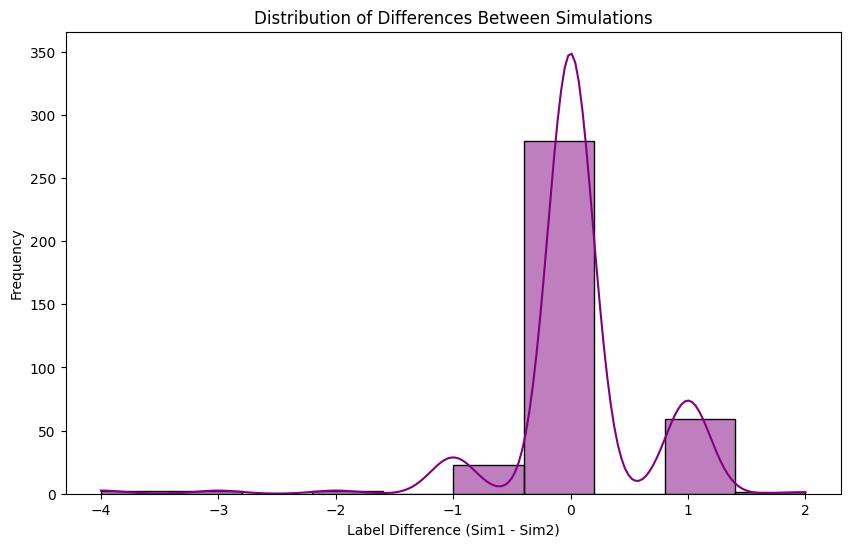

Insufficient data for participant 401
Insufficient data for participant 402
Insufficient data for participant 403
Insufficient data for participant 404
   participant_id  stat   p_value
0             400   3.5  0.057780
1             405   0.0  0.045500
2             406   0.0  0.025597
3             407   0.0  0.317311
4             408   3.5  0.033471
5             409   7.5  0.037571
6             410   0.0  0.014306
7             411   0.0  0.157299
8             412   0.0  0.001054
9             413   0.0  0.038434
10            414   5.0  1.000000
Kruskal-Wallis Test: Stat=25.76348735636512, p-value=9.917125505682423e-05


c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

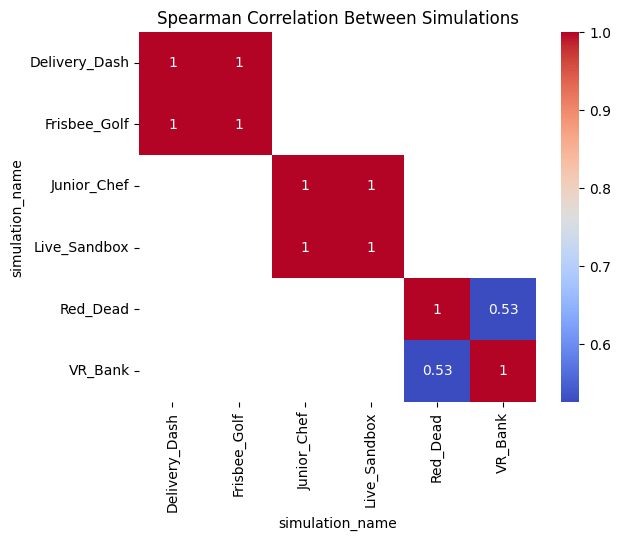

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, kruskal, spearmanr, ttest_rel
import numpy as np

# Example DataFrame (replace with your dataset)
# df = pd.read_csv('your_data.csv')
df = data_df
# Descriptive Statistics
group_stats = df.groupby('simulation_name')['label'].describe()
print(group_stats)

# Boxplot Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='simulation_name', y='label', palette='Set2')
plt.title('Boxplot of Cybersickness Labels by Simulation')
plt.xlabel('Simulation Name')
plt.ylabel('Cybersickness Label')
plt.show()

# Paired Strip Plot (Participant-Level)
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='simulation_name', y='label', hue='participant_id', jitter=True, dodge=True, palette='tab10')
plt.title('Participant-Level Comparison Between Simulations')
plt.xlabel('Simulation Name')
plt.ylabel('Cybersickness Label')
plt.legend(title='Participant ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Difference Histogram
df['label_diff'] = df.groupby('participant_id')['label'].diff().dropna()
plt.figure(figsize=(10, 6))
sns.histplot(df['label_diff'], kde=True, bins=10, color='purple')
plt.title('Distribution of Differences Between Simulations')
plt.xlabel('Label Difference (Sim1 - Sim2)')
plt.ylabel('Frequency')
plt.show()

# Wilcoxon Signed-Rank Test
paired_results = []
for participant_id, group in df.groupby('participant_id'):
    if group['simulation_name'].nunique() == 2:
        sim1, sim2 = group.groupby('simulation_name')['label']
        try:
            stat, p_value = wilcoxon(sim1[1], sim2[1])
            paired_results.append({'participant_id': participant_id, 'stat': stat, 'p_value': p_value})
        except ValueError:
            print(f"Insufficient data for participant {participant_id}")
paired_results_df = pd.DataFrame(paired_results)
print(paired_results_df)

# Kruskal-Wallis Test (Group-Level Comparison)
kruskal_stat, kruskal_p = kruskal(*[group['label'] for _, group in df.groupby('simulation_name')])
print(f"Kruskal-Wallis Test: Stat={kruskal_stat}, p-value={kruskal_p}")

# Correlation Heatmap
correlation_matrix = df.pivot_table(index='participant_id', columns='simulation_name', values='label').corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Spearman Correlation Between Simulations')
plt.show()


In [47]:
def cohens_d(x, y):
    diff = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt((np.var(x) + np.var(y)) / 2)
    return diff / pooled_std

for participant_id, group in df.groupby('participant_id'):
    if group['simulation_name'].nunique() == 2:
        sim1, sim2 = group.groupby('simulation_name')['label']
        effect_size = cohens_d(sim1[1], sim2[1])
        print(f"Participant {participant_id} - Cohen's d: {effect_size:.2f}")


Participant 400 - Cohen's d: -0.58
Participant 401 - Cohen's d: nan
Participant 402 - Cohen's d: nan
Participant 403 - Cohen's d: 0.21
Participant 404 - Cohen's d: -0.58
Participant 405 - Cohen's d: -0.94
Participant 406 - Cohen's d: -1.10
Participant 407 - Cohen's d: -0.41
Participant 408 - Cohen's d: -0.81
Participant 409 - Cohen's d: 0.79
Participant 410 - Cohen's d: -0.72
Participant 411 - Cohen's d: 0.60
Participant 412 - Cohen's d: -3.95
Participant 413 - Cohen's d: 0.94
Participant 414 - Cohen's d: 0.00


C:\Users\jyoti\AppData\Local\Temp\ipykernel_17336\1025287371.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return diff / pooled_std
C:\Users\jyoti\AppData\Local\Temp\ipykernel_17336\1025287371.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return diff / pooled_std


<Figure size 1200x800 with 0 Axes>

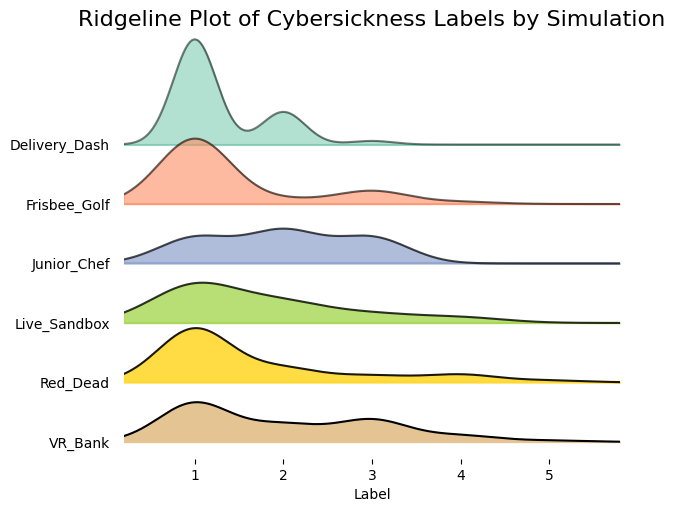

In [ ]:
# !pip install joypy
import joypy

plt.figure(figsize=(12, 8))
joypy.joyplot(data=df, by="simulation_name", column="label", colormap=plt.cm.Set2, fade=True)
plt.title("Ridgeline Plot of Cybersickness Labels by Simulation", fontsize=16)
plt.xlabel("Label")
plt.show()


c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



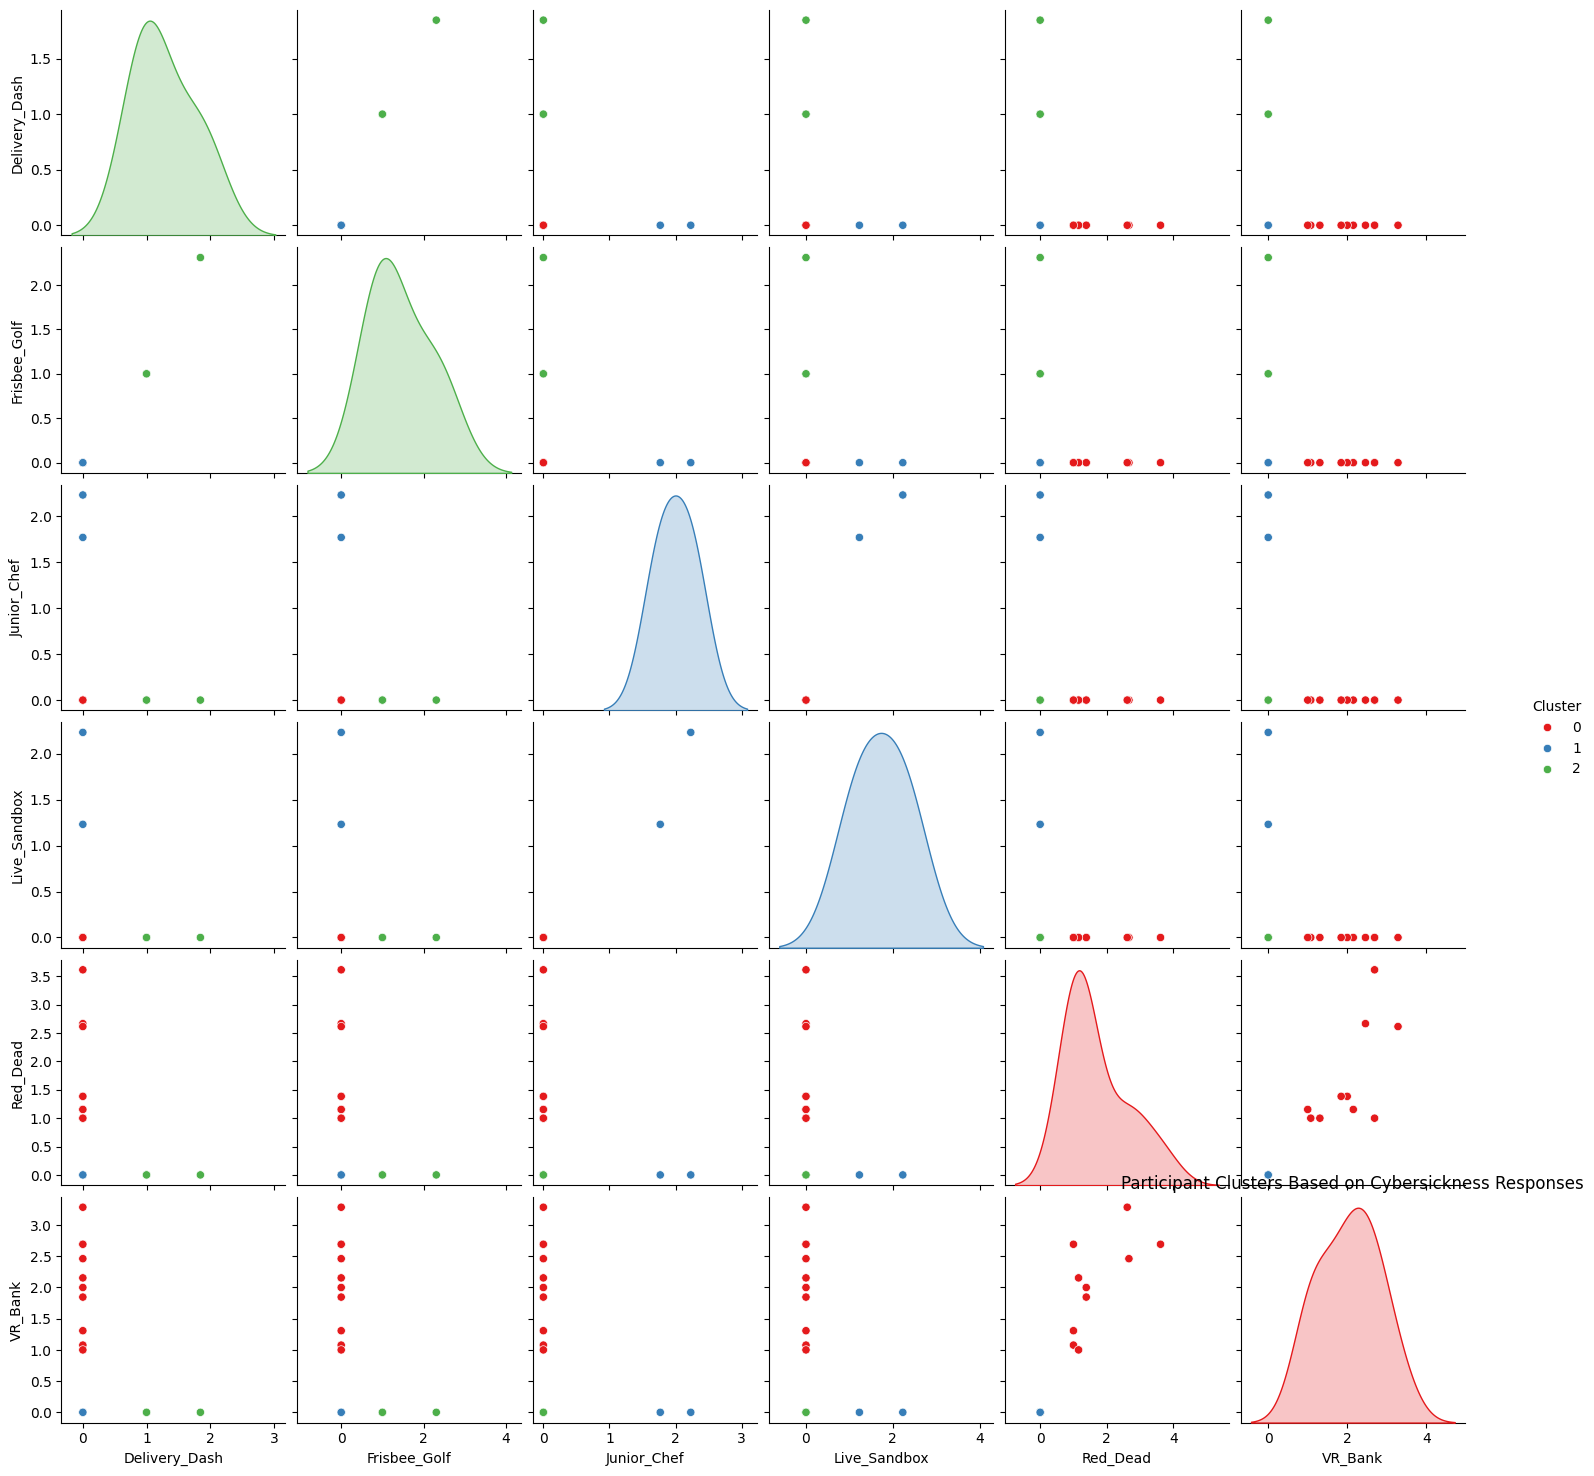

In [55]:
# Aggregating data to handle duplicates (e.g., using mean)
df_aggregated = df.groupby(['participant_id', 'simulation_name'])['label'].mean().reset_index()

# Create pivot table
pivot = df_aggregated.pivot(index='participant_id', columns='simulation_name', values='label').fillna(0)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(pivot)
pivot['Cluster'] = kmeans.labels_

# Visualize clusters
sns.pairplot(pivot.reset_index(), hue="Cluster", palette="Set1")
plt.title("Participant Clusters Based on Cybersickness Responses")
plt.show()


c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 35.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 57.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jyoti\anaconda3\envs\save\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 54.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\jyoti\AppData\Local\Temp\ipykernel_17336\2461605581.py:

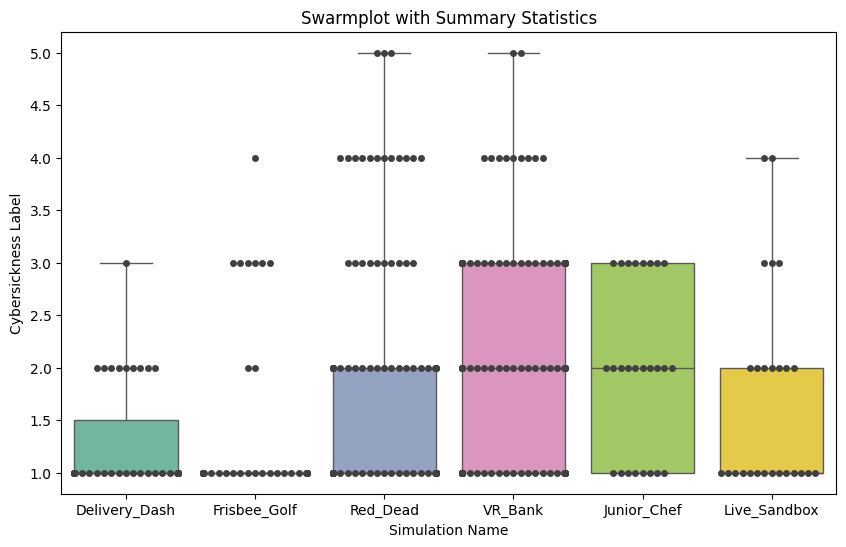

In [50]:
plt.figure(figsize=(10, 6))
sns.swarmplot(data=df, x='simulation_name', y='label', color=".25")
sns.boxplot(data=df, x='simulation_name', y='label', whis=np.inf, palette="Set2", showfliers=False)
plt.title('Swarmplot with Summary Statistics')
plt.xlabel('Simulation Name')
plt.ylabel('Cybersickness Label')
plt.show()


In [ ]:
# !pip install statsmodels
import statsmodels.formula.api as smf

model = smf.mixedlm("label ~ simulation_name", df, groups="participant_id")
result = model.fit()
print(result.summary())


   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB 640.0 kB/s eta 0:00:16
   ---------------------------------------- 0.1/9.9 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.3/9.9 MB 3.0 MB/s eta 0:00:04
   -- ------------------------------------- 0.7/9.9 MB 4.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.2/9.9 MB 5.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.9 MB 6.9 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.9 MB 6.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.3/9.9 MB 6.9 MB/s eta 0:00:02
   ----------- ---------------------------- 2.8/9.9 MB 7.7 MB/s eta 0:00:01
   ------------- -------------------------- 3.3/9.9 MB 8.2 MB/s eta 0:00:01
   --------------- ------------------------ 3.8/9.9 MB 8.5 MB/s eta 0:00:01
   ----------------- ---------------------- 4.3/9.9 MB 8.9 MB/s eta 0:00:01
   --------------

C:\Users\jyoti\AppData\Local\Temp\ipykernel_17336\3267191771.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




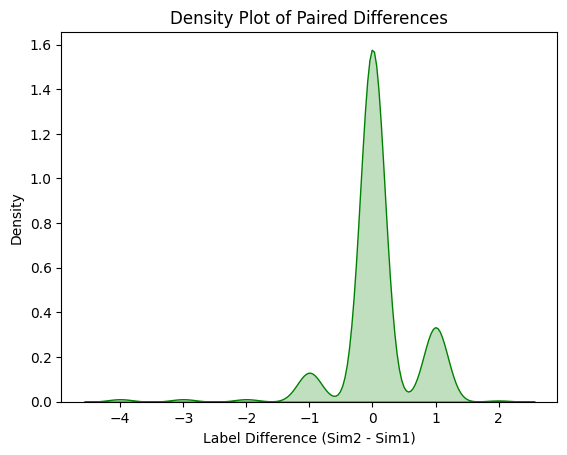

In [58]:
df['label_diff'] = df.groupby('participant_id')['label'].diff().dropna()
sns.kdeplot(df['label_diff'], shade=True, color="green")
plt.title("Density Plot of Paired Differences")
plt.xlabel("Label Difference (Sim2 - Sim1)")
plt.ylabel("Density")
plt.show()
